Copyright 2022 Andrew M. Olney and made available under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0) for text and [Apache-2.0](http://www.apache.org/licenses/LICENSE-2.0) for code.

# Crossvalidation and Nested crossvalidation: Problem solving

In this session, you will apply nested crossvalidation to logistic lasso regression, to find the optimal regularization parameter (or penalty term) for predicting breast cancer.

The [data](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset) consists of the following variables as mean, standard error, and "worst" (mean of three largest variables) collected by digital imagery of a biopsy.

| Variable | Type | Description |
|:-------|:-------|:-------|
|radius | Ratio | mean of distances from center to points on the perimeter|
|texture | Ratio | standard deviation of gray-scale values|
|perimeter | Ratio | perimeter of cancer|
|area | Ratio | area of cancer|
|smoothness | Ratio | local variation in radius lengths|
|compactness | Ratio |  perimeter^2 / area - 1.0|
|concavity | Ratio |  severity of concave portions of the contour|
|concave points | Ratio |  number of concave portions of the contour|
|symmetry | Ratio | symmetry of cancer|
|fractal dimension | Ratio | "coastline approximation" - 1|

<div style="text-align:center;font-size: smaller">
    <b>Source:</b> This dataset was taken from the <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">UCI Machine Learning Repository library
    </a>
</div>
<br>


In addition to these predictors is the class label:

| Variable | Type | Description |
|:-------|:-------|:-------|
| Target | Nominal (binary) | malignant (1) or benign (0)


The goal is to predict `Target`, i.e. the presence of breast cancer.

### Load data

Start by loading `readr`, `tidyr`, `dplyr`, and `base` so we can read data into a dataframe and manipulate it.

In [1]:
library(readr)
library(dplyr)
library(base)
library(tidyr)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="_;PP-/]_2fNUR.dyhw(8">readr</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="6C!l+@S8,SvtzakmsxQD">base</variable><variable id="%ovw[;dNkqx,|V0M/RZA">tidyr</variable></variables><block type="import_R" id="q]np1Ju|B`4k*R-zylwU" x="44" y="66"><field name="libraryName" id="_;PP-/]_2fNUR.dyhw(8">readr</field><next><block type="import_R" id="(%@0XC,((6M%4]kj+iDm"><field name="libraryName" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><next><block type="import_R" id="AmB3B[T@UHq1l2P*NjUF"><field name="libraryName" id="6C!l+@S8,SvtzakmsxQD">base</field><next><block type="import_R" id="y2|Swk~j;9*y~/$%m|e%"><field name="libraryName" id="%ovw[;dNkqx,|V0M/RZA">tidyr</field></block></next></block></next></block></next></block></xml>


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Load the dataframe with `datasets/cancer.csv`.

In [2]:
dataframe = readr::read_csv("datasets/cancer.csv")

dataframe

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id="_;PP-/]_2fNUR.dyhw(8">readr</variable></variables><block type="variables_set" id="gM*jw`FfIR3)8=g0iEB7" x="-102" y="28"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field><value name="VALUE"><block type="varDoMethod_R" id=",vaW{t?FHN1~E?+,h!w-"><mutation items="1"></mutation><field name="VAR" id="_;PP-/]_2fNUR.dyhw(8">readr</field><field name="MEMBER">read_csv</field><data>readr:read_csv</data><value name="ADD0"><block type="text" id="dfrpI5b@DHr+DQ:|@vpv"><field name="TEXT">datasets/cancer.csv</field></block></value></block></value></block><block type="variables_get" id="dn{+Q#DO%lN;G_tFGJ#B" x="-114" y="118"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></xml>

Rows: 569 Columns: 31
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (31): mean radius, mean texture, mean perimeter, mean area, mean smoothn...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
18.25,19.98,119.60,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,0.2128,0.07152,0.2602,1.205,2.362,22.65,0.004625,0.04844,0.07359,0.01608,0.02137,0.006142,17.520,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.2356,0.4089,0.14090,0


## Explore data

Load `ggplot2`,`corrr`, and `psych`.

In [3]:
library(ggplot2)
library(psych)
library(corrr)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable><variable id="-%rFagMkPz%VG@$q~ANP">psych</variable><variable id=":}mQPTQxRKZMh,T7NR$$">corrr</variable></variables><block type="import_R" id="n?whQI8t]Qj6)k-ny|GN" x="-79" y="-22"><field name="libraryName" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><next><block type="import_R" id="P-VMU%%i=n!?0`h3v|jE"><field name="libraryName" id="-%rFagMkPz%VG@$q~ANP">psych</field><next><block type="import_R" id="KM{Rbpc4Yc@sV3GgakYX"><field name="libraryName" id=":}mQPTQxRKZMh,T7NR$$">corrr</field></block></next></block></next></block></xml>

Warning message:
“package ‘ggplot2’ was built under R version 4.2.2”

Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




Check for NA using `summary`.

In [4]:
base::summary(dataframe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="6C!l+@S8,SvtzakmsxQD">base</variable><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable></variables><block type="varDoMethod_R" id="6T1RT@wyK3uN|W4GOJs~" x="-352" y="128"><mutation items="1"></mutation><field name="VAR" id="6C!l+@S8,SvtzakmsxQD">base</field><field name="MEMBER">summary</field><data>base:summary</data><value name="ADD0"><block type="variables_get" id="+iZ-{u+.wd6DPMhYf:MV"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value></block></xml>

  mean radius      mean texture   mean perimeter     mean area     
 Min.   : 6.981   Min.   : 9.71   Min.   : 43.79   Min.   : 143.5  
 1st Qu.:11.700   1st Qu.:16.17   1st Qu.: 75.17   1st Qu.: 420.3  
 Median :13.370   Median :18.84   Median : 86.24   Median : 551.1  
 Mean   :14.127   Mean   :19.29   Mean   : 91.97   Mean   : 654.9  
 3rd Qu.:15.780   3rd Qu.:21.80   3rd Qu.:104.10   3rd Qu.: 782.7  
 Max.   :28.110   Max.   :39.28   Max.   :188.50   Max.   :2501.0  
                                                                   
 mean smoothness   mean compactness  mean concavity     mean concave points
 Min.   :0.05263   Min.   :0.01938   Min.   :0.000692   Min.   :0.001852   
 1st Qu.:0.08637   1st Qu.:0.06492   1st Qu.:0.030880   1st Qu.:0.020895   
 Median :0.09587   Median :0.09263   Median :0.064905   Median :0.034840   
 Mean   :0.09636   Mean   :0.10434   Mean   :0.090876   Mean   :0.050063   
 3rd Qu.:0.10530   3rd Qu.:0.13040   3rd Qu.:0.132325   3rd Qu.:0.074842   


Since there are clearly some NaN, `dropna` and store the results back into your dataframe.

In [5]:
dataframe = tidyr::drop_na(dataframe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id="%ovw[;dNkqx,|V0M/RZA">tidyr</variable></variables><block type="variables_set" id="+MP3GW)yhZ@;C8W~pM+:" x="-307" y="131"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field><value name="VALUE"><block type="varDoMethod_R" id="!%e):ia!]Lh:c~XsZ!$("><mutation items="1"></mutation><field name="VAR" id="%ovw[;dNkqx,|V0M/RZA">tidyr</field><field name="MEMBER">drop_na</field><data>tidyr:drop_na</data><value name="ADD0"><block type="variables_get" id="|s~ukfP2y.Wdn,oYw#u+"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value></block></value></block></xml>

Check the data makes sense with `describe`.

In [6]:
psych::describe(dataframe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="-%rFagMkPz%VG@$q~ANP">psych</variable><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable></variables><block type="varDoMethod_R" id="!%e):ia!]Lh:c~XsZ!$(" x="-189" y="228"><mutation items="1"></mutation><field name="VAR" id="-%rFagMkPz%VG@$q~ANP">psych</field><field name="MEMBER">describe</field><data>psych:describe</data><value name="ADD0"><block type="variables_get" id="|s~ukfP2y.Wdn,oYw#u+"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value></block></xml>

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mean radius,1,556,14.23756475,3.48216987,13.455000,13.91757848,2.77987500,7.691e+00,28.1100,20.419000,0.9742934,0.8405897,0.147676897
mean texture,2,556,19.25974820,4.24699261,18.855000,19.01782511,4.09938900,9.710e+00,39.2800,29.570000,0.6506971,0.8322587,0.180112606
mean perimeter,3,556,92.73667266,24.00636223,87.090000,90.41585202,19.54808100,4.834e+01,188.5000,140.160000,1.0246285,0.9716833,1.018096534
mean area,4,556,663.73471223,350.89331337,557.650000,614.36547085,228.69105000,1.704e+02,2501.0000,2330.600000,1.6485301,3.6076759,14.881191195
mean smoothness,5,556,0.09661649,0.01389530,0.096035,0.09608036,0.01388455,6.251e-02,0.1634,0.100890,0.5127771,0.8218191,0.000589292
mean compactness,6,556,0.10567879,0.05264255,0.095090,0.09941975,0.04862928,1.938e-02,0.3454,0.326020,1.1825378,1.6100652,0.002232541
mean concavity,7,556,0.09087556,0.07946754,0.064905,0.07921836,0.06116466,6.920e-04,0.4268,0.426108,1.3943827,1.9473521,0.003370174
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
worst smoothness,25,556,0.13282448,0.02261624,0.131550,0.1319572,0.02157183,0.081250,0.2226,0.141350,0.4483410,0.5050618,0.0009591422


-----------
**QUESTION:**

Do the min, mean, and max look reasonable to you?

**ANSWER: (click here to edit)**

*I really can't say; I don't have enough medical knowledge to fully understand these variables.*

--------------------

**QUESTION:**

What percentage of the data has `Target=1` and `Target=0`?

**ANSWER: (click here to edit)**

*Since `Target` is 0 or 1, and the mean is .618, `Target=1` is 61.8% of the data and `Target=0` is 38.2%*

--------------------

To look at the correlations between variables, create a correlation heatmap.

And create a correlation matrix.

Correlation computed with
• Method: 'pearson'
• Missing treated using: 'pairwise.complete.obs'


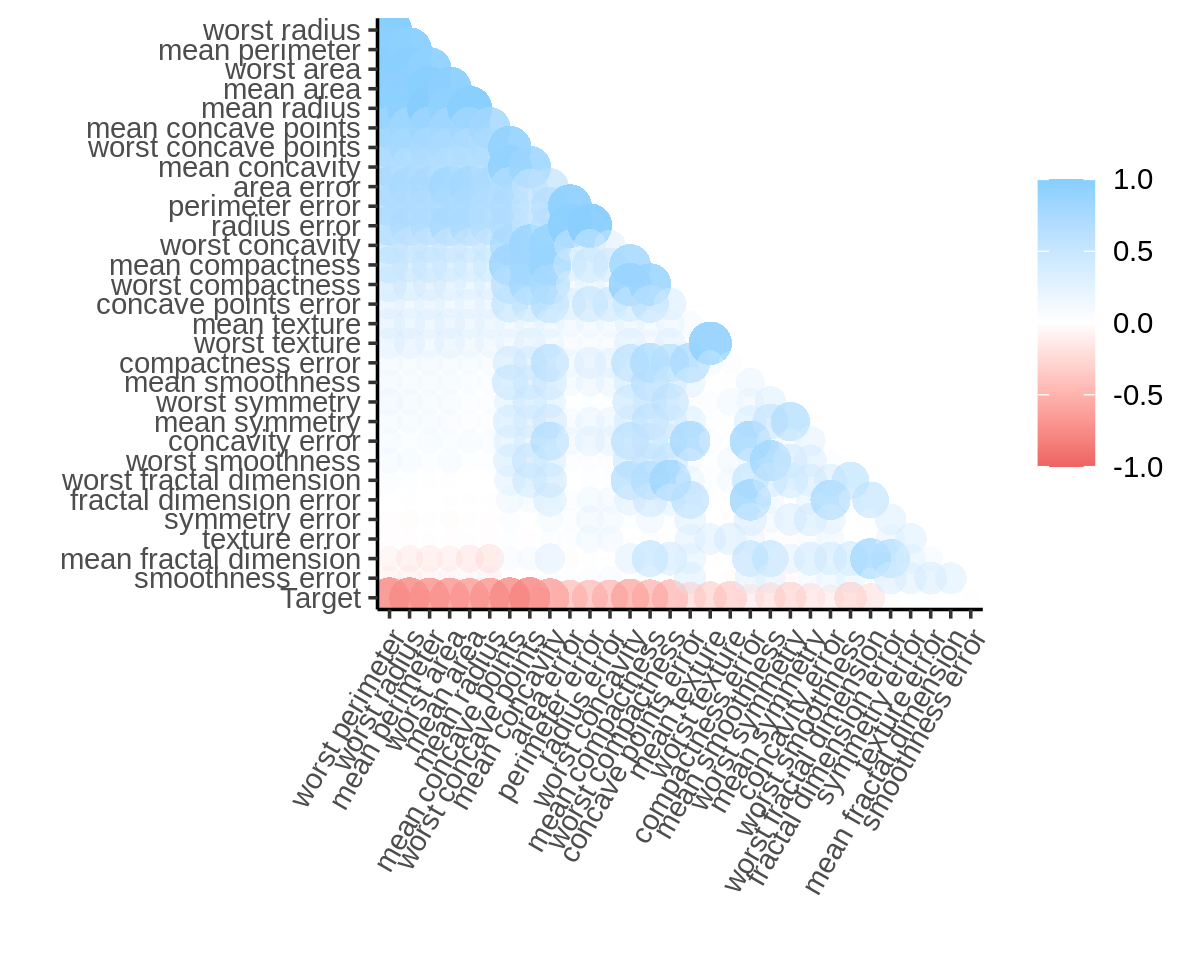

In [7]:
dataframe %>%
    corrr::correlate() %>%
    corrr::rearrange() %>%
    corrr::shave() %>%
    corrr::rplot() +
    ggplot2::theme(axis.text.x = element_text(angle = 60, hjust = 1))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id=":}mQPTQxRKZMh,T7NR$$">corrr</variable><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable></variables><block type="pipe_R" id="N12|vt`l[nbbEa%Y~#m8" x="-52" y="-175"><mutation items="4"></mutation><value name="INPUT"><block type="variables_get" id="gVhqUlh8Cy^F.8HkQSR$"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="!IGLlvXdM16CaY84=Bg6"><mutation items="1"></mutation><field name="VAR" id=":}mQPTQxRKZMh,T7NR$$">corrr</field><field name="MEMBER">correlate</field><data>corrr:correlate</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="}:lkTT23H2F#0KMm`|,/"><mutation items="1"></mutation><field name="VAR" id=":}mQPTQxRKZMh,T7NR$$">corrr</field><field name="MEMBER">rearrange</field><data>corrr:rearrange</data></block></value><value name="ADD2"><block type="varDoMethod_R" id="O/(t7,oDux_+[+q!kGh6"><mutation items="1"></mutation><field name="VAR" id=":}mQPTQxRKZMh,T7NR$$">corrr</field><field name="MEMBER">shave</field><data>corrr:shave</data></block></value><value name="ADD3"><block type="ggplot_plus_R" id="3ilR0aqrIo(uJr*!6bpU"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="=#E:Zp_ck$*)mk/i8`^K"><mutation items="1"></mutation><field name="VAR" id=":}mQPTQxRKZMh,T7NR$$">corrr</field><field name="MEMBER">rplot</field><data>corrr:rplot</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="f#R*ao;9?HYu9{XmEY3r"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">theme</field><data>ggplot2:theme</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="@ce!p}8ffHehsPmXP[bV"><field name="CODE">axis.text.x = element_text(angle = 60, hjust = 1)</field></block></value></block></value></block></value></block></xml>

-----------
**QUESTION:**

What can you say about the correlations amongst the variables?

**ANSWER: (click here to edit)**

*Many of the variables are somewhat correlated with the others. 
Finally, the class label seems to be negatively correlated with many of the variables and not correlated with a small number of them.*

--------------------


**QUESTION:**

Are there any more plots you'd want to do at this point? Why or why not?

**ANSWER: (click here to edit)**

*We already have the class imbalance from the descriptives. 
We could do a scatterplot matrix to look for nonlinear relationships since that is important for logistic regression.*

--------------------

### Prepare train/test sets

Load the package for splitting.

In [8]:
library(rsample)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="~~-I(f=60)#JfKGvV_AP">rsample</variable></variables><block type="import_R" id="aFBwKpYz$V@3rI9Nk71a" x="-280" y="10"><field name="libraryName" id="~~-I(f=60)#JfKGvV_AP">rsample</field></block></xml>

Warning message:
“package ‘rsample’ was built under R version 4.2.2”


Now split the data, but first specify a random seed of `2` and convert `Target` to a factor.

In [16]:
base::set.seed(2)

dataframe = dplyr::mutate(dataframe,Target=factor(Target))

data_split = rsample::initial_split(dataframe,prop=.80)
data_train = rsample::training(data_split)
data_test = rsample::testing(data_split)

data_train

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="6C!l+@S8,SvtzakmsxQD">base</variable><variable id="bQ!4E:J!~]0(]7KV]m@=">data_split</variable><variable id=":iMr},W7(N7vSLAUw!ao">data_train</variable><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id="~~-I(f=60)#JfKGvV_AP">rsample</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="|q$XCeTWL%AdgT|]tbnU">data_test</variable></variables><block type="varDoMethod_R" id="Bs.?L_yk:!JU:!D9$e:2" x="-110" y="151"><mutation items="1"></mutation><field name="VAR" id="6C!l+@S8,SvtzakmsxQD">base</field><field name="MEMBER">set.seed</field><data>base:set.seed</data><value name="ADD0"><block type="math_number" id="y3|#H:ii-(np[L}nH,7)"><field name="NUM">2</field></block></value></block><block type="variables_set" id="]OH]28zIzsFO]3f~bu)?" x="-99" y="217"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field><value name="VALUE"><block type="varDoMethod_R" id="MEv6@Bh7!uR5d7AZ|@5I"><mutation items="2"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">mutate</field><data>dplyr:mutate</data><value name="ADD0"><block type="variables_get" id="G_k+[?=XAhOh}/K)4257"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="GkcKa]N`o!z$,Bak1^A{"><field name="CODE">Target=factor(Target)</field></block></value></block></value></block><block type="variables_set" id="s!g),aa^(]dox/f`@P!y" x="-116" y="302"><field name="VAR" id="bQ!4E:J!~]0(]7KV]m@=">data_split</field><value name="VALUE"><block type="varDoMethod_R" id="hPsr6}9C/VNgaLsKuR,o"><mutation items="2"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">initial_split</field><data>rsample:initial_split</data><value name="ADD0"><block type="variables_get" id="]~#@ltf];dTom_%pzV4n"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="R`?vH79hsA6Duxa9)AFX"><field name="CODE">prop=.80</field></block></value></block></value><next><block type="variables_set" id="3J6#JDFV0wE?V;NuM=?L"><field name="VAR" id=":iMr},W7(N7vSLAUw!ao">data_train</field><value name="VALUE"><block type="varDoMethod_R" id="X|Q7lj,pD_9W{%^.xd7h"><mutation items="1"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">training</field><data>rsample:training</data><value name="ADD0"><block type="variables_get" id="JFCmHyJPiN`qwnlE~:iT"><field name="VAR" id="bQ!4E:J!~]0(]7KV]m@=">data_split</field></block></value></block></value><next><block type="variables_set" id="Y]ag(g~}tkN6:_X*]6P{"><field name="VAR" id="|q$XCeTWL%AdgT|]tbnU">data_test</field><value name="VALUE"><block type="varDoMethod_R" id="WBYo8G|ZcojJAqETRnv`"><mutation items="1"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">testing</field><data>rsample:testing</data><value name="ADD0"><block type="variables_get" id="p^~x9|Zj((6qaUVvj#.E"><field name="VAR" id="bQ!4E:J!~]0(]7KV]m@=">data_split</field></block></value></block></value></block></next></block></next></block><block type="variables_get" id="9j){6[r67+7OFx`a~K[Y" x="-115" y="515"><field name="VAR" id=":iMr},W7(N7vSLAUw!ao">data_train</field></block></xml>

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
11.61,16.02,75.46,408.2,0.10880,0.11680,0.07097,0.044970,0.1886,0.06320,0.2456,0.7339,1.667,15.89,0.005884,0.02005,0.02631,0.013040,0.01848,0.001982,12.64,19.67,81.93,475.7,0.14150,0.2170,0.2302,0.11050,0.2787,0.07427,1
11.06,14.83,70.31,378.2,0.07741,0.04768,0.02712,0.007246,0.1535,0.06214,0.1855,0.6881,1.263,12.98,0.004259,0.01469,0.01940,0.004168,0.01191,0.003537,12.68,20.35,80.79,496.7,0.11200,0.1879,0.2079,0.05556,0.2590,0.09158,1
18.81,19.98,120.90,1102.0,0.08923,0.05884,0.08020,0.058430,0.1550,0.04996,0.3283,0.8280,2.363,36.74,0.007571,0.01114,0.02623,0.014630,0.01930,0.001676,19.96,24.30,129.00,1236.0,0.12430,0.1160,0.2210,0.12940,0.2567,0.05737,0
11.14,14.07,71.24,384.6,0.07274,0.06064,0.04505,0.014710,0.1690,0.06083,0.4222,0.8092,3.330,28.84,0.005541,0.03387,0.04505,0.014710,0.03102,0.004831,12.12,15.82,79.62,453.5,0.08864,0.1256,0.1201,0.03922,0.2576,0.07018,1
13.11,22.54,87.02,529.4,0.10020,0.14830,0.08705,0.051020,0.1850,0.07310,0.1931,0.9223,1.491,15.09,0.005251,0.03041,0.02526,0.008304,0.02514,0.004198,14.55,29.16,99.48,639.3,0.13490,0.4402,0.3162,0.11260,0.4128,0.10760,1
12.21,14.09,78.78,462.0,0.08108,0.07823,0.06839,0.025340,0.1646,0.06154,0.2666,0.8309,2.097,19.96,0.004405,0.03026,0.04344,0.010870,0.01921,0.004622,13.13,19.29,87.65,529.9,0.10260,0.2431,0.3076,0.09140,0.2677,0.08824,1
12.46,19.89,80.43,471.3,0.08451,0.10140,0.06830,0.030990,0.1781,0.06249,0.3642,1.0400,2.579,28.32,0.006530,0.03369,0.04712,0.014030,0.02740,0.004651,13.46,23.07,88.13,551.3,0.10500,0.2158,0.1904,0.07625,0.2685,0.07764,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
14.48,21.46,94.25,648.2,0.09444,0.09947,0.12040,0.04938,0.2075,0.05636,0.4204,2.2200,3.301,38.87,0.009369,0.029830,0.053710,0.017610,0.02418,0.003249,16.21,29.25,108.40,808.9,0.1306,0.1976,0.33490,0.12250,0.3020,0.06846,0


### Train model with nested crossvalidation

Load the `recipes` and `workflows` packages, along with `parsnip`, `generics`, `hardhat`, `discrim`, `yardstick`, `broom`, and `tune`.

In [17]:
library(recipes)
library(workflows)
library(generics)
library(parsnip)
library(hardhat)
library(broom)
library(discrim)
library(tune)
library(yardstick)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="{5PU6CE0j[[^yJ79kBMR">hardhat</variable><variable id="Ubl?FFCN5uCFfCTQ?7:z">broom</variable><variable id="w!D@.AsJTNGfyfT07ttG">discrim</variable><variable id="P9;RzeN25v*`uh$NdfXd">tune</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable></variables><block type="import_R" id="EGE;dT.cnN,o}Y[99#Qb" x="6" y="15"><field name="libraryName" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><next><block type="import_R" id="6DrE-26ByLD$vC}QeW:}"><field name="libraryName" id="haMDnc8Uj|EjY^608!;]">workflows</field><next><block type="import_R" id="hQ4(=]9%QB3(VWqs9OK:"><field name="libraryName" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><next><block type="import_R" id="d1vIIBH:{ygkVLV/Ts5l"><field name="libraryName" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><next><block type="import_R" id="vFfUgs[O$$~/VO1yVa~v"><field name="libraryName" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><next><block type="import_R" id="cegz.xTQ~Bq[q~wqZQHD"><field name="libraryName" id="Ubl?FFCN5uCFfCTQ?7:z">broom</field><next><block type="import_R" id="woT+;7kaSfjsFo7!kbL@"><field name="libraryName" id="w!D@.AsJTNGfyfT07ttG">discrim</field><next><block type="import_R" id="a@ke{uWOBz.cGHew5^bE"><field name="libraryName" id="P9;RzeN25v*`uh$NdfXd">tune</field><next><block type="import_R" id="w=n3fFxd6.xE]tegxU.u"><field name="libraryName" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field></block></next></block></next></block></next></block></next></block></next></block></next></block></next></block></next></block></xml>

Make folds from the training data.
These will be the outer folds.

In [18]:
folds = rsample::vfold_cv(data_train,v=10,strata="Target")

print(folds);

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Jf`Hc(Jw6)c^J2094GU-">folds</variable><variable id="~~-I(f=60)#JfKGvV_AP">rsample</variable><variable id=":iMr},W7(N7vSLAUw!ao">data_train</variable></variables><block type="variables_set" id="fbB[H3;f3-u]ZOIN+1r=" x="-270" y="117"><field name="VAR" id="Jf`Hc(Jw6)c^J2094GU-">folds</field><value name="VALUE"><block type="varDoMethod_R" id="rzcA-ECrv`a,x/6tPRRW"><mutation items="3"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">vfold_cv</field><data>rsample:vfold_cv</data><value name="ADD0"><block type="variables_get" id="I4A@g,F]E)99z=`g/TC{"><field name="VAR" id=":iMr},W7(N7vSLAUw!ao">data_train</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="9qXIO^)h[sQg,_kuOG[s"><field name="CODE">v=10</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="[8o:?WELg3[g*Ju=?#fi"><field name="CODE">strata="Target"</field></block></value></block></value></block><block type="text_print" id="OlAlA6O?w1qevz![p:YH" x="-269" y="347"><value name="TEXT"><shadow type="text" id="Aq_a5^(xlt.P2fX8{l/0"><field name="TEXT">abc</field></shadow><block type="variables_get" id="vAXKyb{NRE2oF~)4-*-{"><field name="VAR" id="Jf`Hc(Jw6)c^J2094GU-">folds</field></block></value></block></xml>

#  10-fold cross-validation using stratification 
# A tibble: 10 × 2
   splits           id    
   <list>           <chr> 
 1 <split [399/45]> Fold01
 2 <split [399/45]> Fold02
 3 <split [399/45]> Fold03
 4 <split [399/45]> Fold04
 5 <split [400/44]> Fold05
 6 <split [400/44]> Fold06
 7 <split [400/44]> Fold07
 8 <split [400/44]> Fold08
 9 <split [400/44]> Fold09
10 <split [400/44]> Fold10


Make a workflow for a logistic lasso model suitable for grid search. 
The `penalty` parameter should be set up for grid search.

In [19]:
recipe = recipes::recipe(Target ~ .,data = data_train) %>%
    recipes::step_normalize(recipes::all_numeric_predictors())
model = parsnip::logistic_reg(penalty =  tune(),mixture=1) %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("glmnet")
workflow = workflows::workflow() %>%
    workflows::add_model(model) %>%
    workflows::add_recipe(recipe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Oz8-33unXZJ?3~@*32r-">recipe</variable><variable id="mgo;O)iX^5)A5.@gqIkA">model</variable><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable></variables><block type="variables_set" id="w{}j6,P|-6Qepjtz/mj{" x="77" y="213"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field><value name="VALUE"><block type="pipe_R" id="uzp8+LCnH{r`1Xn%3mdK"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="U^,K1TWD+}odaY!kExkh"><mutation items="2"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">recipe</field><data>recipes:recipe</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Target ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = data_train</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="5=08G^e872=?+){KI?5}"><mutation items="1"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">step_normalize</field><data>recipes:step_normalize</data><value name="ADD0"><block type="varDoMethod_R" id="DEvi*v6Y{#}d{h35/S#3"><mutation items="1"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">all_numeric_predictors</field><data>recipes:all_numeric_predictors</data></block></value></block></value></block></value><next><block type="variables_set" id="*(u89h_-M@(PB-!qP/1l"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field><value name="VALUE"><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">logistic_reg</field><data>parsnip:logistic_reg</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="iP`lGU_Nf!$/q0V2={b8"><field name="CODE">penalty =  tune()</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="moh3t+HVZBsRw[TU90pG"><field name="CODE">mixture=1</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">glmnet</field></block></value></block></value></block></value><next><block type="variables_set" id="f%c#[D)Zv:uHH6WY_TQI"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field><value name="VALUE"><block type="pipe_R" id="Rk~*~r(!3iF+cvcz7IiD"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="H!7?PcsriTx,;-jJmb`7"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">workflow</field><data>workflows:workflow</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="CrWn^(|[{],FV=/-Jt!b"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_model</field><data>workflows:add_model</data><value name="ADD0"><block type="variables_get" id="7MGIpZZh#XkK`d+ZY4h:"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="L1.O)ZR~Ab`VSER(L}FZ"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_recipe</field><data>workflows:add_recipe</data><value name="ADD0"><block type="variables_get" id="U.@@S3Rdx{:xKxE[Fsx]"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field></block></value></block></value></block></value></block></next></block></next></block></xml>

Train the model using nested crossvalidation with grid search on the inner folds.
Save your grid search results and workflow results for the outer folds that use the best grid search parameter from the inner folds.

In [ ]:
crossvalidation_list = list()
grid_search_list = list()
splits = dplyr::pull(folds,splits)
for (i in splits) {
  print(i[["id"]]);
  inner_folds = rsample::vfold_cv(rsample::analysis(i),v=5,strata="Target")
  grid_search_results = workflow %>%
      tune::tune_grid(resamples = folds,metrics = metric_set(accuracy,precision,recall,f_meas))
  inner_folds_best = tune::show_best(grid_search_results,metric="f_meas")
  grid_search_list = base::append(grid_search_list,list(inner_folds_best))
  best_cost = inner_folds_best %>%
      dplyr::slice_head() %>%
      dplyr::pull(penalty)
  best_workflow = workflows::workflow() %>%
      workflows::add_model(parsnip::logistic_reg(penalty=best_cost,mixture=1) %>%
      parsnip::set_mode("classification") %>%
      parsnip::set_engine("glmnet")) %>%
      workflows::add_recipe(recipe)
  crossvalidation_list = base::append(crossvalidation_list,best_workflow %>%
      generics::fit(data = analysis(i)) %>%
      generics::augment(rsample::assessment(i)) %>%
      yardstick::f_meas(truth=Target,estimate=.pred_class) %>%
      list())
}

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</variable><variable id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</variable><variable id="K`{Hz~!9ZuG0HZx]xtEb">splits</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="%=F{E~)glz/Ed)+z[yb[">i</variable><variable id="Jf`Hc(Jw6)c^J2094GU-">folds</variable><variable id="|=7/P%?=Uxn2!yj0VEEx">inner_folds</variable><variable id="~~-I(f=60)#JfKGvV_AP">rsample</variable><variable id="2mpAJ#qVQ!+So89zduro">grid_search_results</variable><variable id="qfFE]a![lf{?yV,L11~N">inner_folds_best</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="P9;RzeN25v*`uh$NdfXd">tune</variable><variable id="6C!l+@S8,SvtzakmsxQD">base</variable><variable id="$ybdXEG(`9%z[8,F%0*D">best_cost</variable><variable id="112D;e=?c4oPp[3x2GfV">best_workflow</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable><variable id="Oz8-33unXZJ?3~@*32r-">recipe</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable></variables><block type="variables_set" id="uo6KJ,h/mk3.:a{_:m.x" x="-307" y="-209"><field name="VAR" id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</field><value name="VALUE"><block type="lists_create_with" id="`*2CC7.|arRQQ@*igTe1"><mutation items="0"></mutation></block></value><next><block type="variables_set" id="-b(D7MFQr6cL,wn?ek#K"><field name="VAR" id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</field><value name="VALUE"><block type="lists_create_with" id="4=)CS3C2^2@;$cunG?WO"><mutation items="0"></mutation></block></value><next><block type="variables_set" id="Nsq`(C)K}Z|9TeO{Qd`1"><field name="VAR" id="K`{Hz~!9ZuG0HZx]xtEb">splits</field><value name="VALUE"><block type="varDoMethod_R" id="Ur}KWOInYJJ:/~(VNr?#"><mutation items="2"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">pull</field><data>dplyr:pull</data><value name="ADD0"><block type="variables_get" id="vo-LwGPlPNNC7qEnRDW{"><field name="VAR" id="Jf`Hc(Jw6)c^J2094GU-">folds</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="c8LZ2,:E}Q1W92EE46Uz"><field name="CODE">splits</field></block></value></block></value><next><block type="controls_forEach" id="/^lHH-KTe%`Lz6%OE1I3"><field name="VAR" id="%=F{E~)glz/Ed)+z[yb[">i</field><value name="LIST"><block type="variables_get" id="PhxvKO;U]f4O6hbyOIQe"><field name="VAR" id="K`{Hz~!9ZuG0HZx]xtEb">splits</field></block></value><statement name="DO"><block type="text_print" id="yC$fZIfHp$?0k2L2Gk=9"><value name="TEXT"><shadow type="text" id="H-wq5|5mxW5UF9L9E2f5"><field name="TEXT">abc</field></shadow><block type="doubleIndexer_R" id=",^?=2mLu,?#$)b64CS^U"><field name="VAR" id="%=F{E~)glz/Ed)+z[yb[">i</field><value name="INDEX"><block type="text" id="}xC|(.Yj*eH0C-Z{0XHW"><field name="TEXT">id</field></block></value></block></value><next><block type="variables_set" id="PK.Z}:(86V@som|%~M;t"><field name="VAR" id="|=7/P%?=Uxn2!yj0VEEx">inner_folds</field><value name="VALUE"><block type="varDoMethod_R" id="MFk7be+oge:%k/]pa*,y"><mutation items="3"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">vfold_cv</field><data>rsample:vfold_cv</data><value name="ADD0"><block type="varDoMethod_R" id="^q`EP$:e[UI!Fl?sxqk,"><mutation items="1"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">analysis</field><data>rsample:analysis</data><value name="ADD0"><block type="variables_get" id="bQjS[l/B=FdX@f;?V.24"><field name="VAR" id="%=F{E~)glz/Ed)+z[yb[">i</field></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="mph.C$CSmn`a)tZgv4Vb"><field name="CODE">v=5</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="]FJ1#d/*mD2p@N/tpA,B"><field name="CODE">strata="Target"</field></block></value></block></value><next><block type="variables_set" id="t!=8Yv-zy;M[pLt^f)fG"><field name="VAR" id="2mpAJ#qVQ!+So89zduro">grid_search_results</field><value name="VALUE"><block type="pipe_R" id=".lL(]$@G+$Ji)$*ze|%c"><mutation items="1"></mutation><value name="INPUT"><block type="variables_get" id="7~aL+CU!wp%Vc!%0ikk9"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="N_+K_}Rp@aA(Mx)4n25$"><mutation items="2"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">tune_grid</field><data>tune:tune_grid</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id=")#%[U#nF(,cH9VW((Uu7"><field name="CODE">resamples = folds</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="f`#pm5U@)1_;K^/-QbEr"><field name="CODE">metrics = metric_set(accuracy,precision,recall,f_meas)</field></block></value></block></value></block></value><next><block type="variables_set" id="FVrgEO4iQHQGK%L!vxWj"><field name="VAR" id="qfFE]a![lf{?yV,L11~N">inner_folds_best</field><value name="VALUE"><block type="varDoMethod_R" id="}!HBKcB^L`B!irj~AuJA"><mutation items="2"></mutation><field name="VAR" id="P9;RzeN25v*`uh$NdfXd">tune</field><field name="MEMBER">show_best</field><data>tune:show_best</data><value name="ADD0"><block type="variables_get" id="}xleUpG]QPPr3*h-a{7L"><field name="VAR" id="2mpAJ#qVQ!+So89zduro">grid_search_results</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="XP48r,b_fnwOXraE+C,L"><field name="CODE">metric="f_meas"</field></block></value></block></value><next><block type="variables_set" id=".z87IHr*3I#x-iR#hMC^"><field name="VAR" id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</field><value name="VALUE"><block type="varDoMethod_R" id="P0_lqGETL;Iig]?%h8-9"><mutation items="2"></mutation><field name="VAR" id="6C!l+@S8,SvtzakmsxQD">base</field><field name="MEMBER">append</field><data>base:append</data><value name="ADD0"><block type="variables_get" id="SzQs.`/R)lgk22~U`O76"><field name="VAR" id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</field></block></value><value name="ADD1"><block type="lists_create_with" id="_4n[xK`9^|3o0WR|Ps/l"><mutation items="1"></mutation><value name="ADD0"><block type="variables_get" id="lxw~(bYyZL;;r0+aU(Ae"><field name="VAR" id="qfFE]a![lf{?yV,L11~N">inner_folds_best</field></block></value></block></value></block></value><next><block type="variables_set" id="i*o$E#!!hkt!Hnx^)Eg."><field name="VAR" id="$ybdXEG(`9%z[8,F%0*D">best_cost</field><value name="VALUE"><block type="pipe_R" id="*EQ]p,;GuoBv+ddVJhXg"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="1P=IPY0FJ2:):S:27$c,"><field name="VAR" id="qfFE]a![lf{?yV,L11~N">inner_folds_best</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="*LNOAMx?+oM807`:|.F)"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">slice_head</field><data>dplyr:slice_head</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="v*~]mPB=V-o]HY/Wy)aw"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">pull</field><data>dplyr:pull</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="|Nx{4;qJwKq}uy[WY0ck"><field name="CODE">penalty</field></block></value></block></value></block></value><next><block type="variables_set" id="A@nb,})t*rhd(a8fXwf7"><field name="VAR" id="112D;e=?c4oPp[3x2GfV">best_workflow</field><value name="VALUE"><block type="pipe_R" id="ifOLvRhkDy+GOx+^du],"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="LRgWGx=mKjk3|#Kd6i2Q"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">workflow</field><data>workflows:workflow</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="nhc`+A_0ZGk);)z4,I4O"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_model</field><data>workflows:add_model</data><value name="ADD0"><block type="pipe_R" id="k}t0;Sb.`-I,|Auh%FiV"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="(0J$)W*BfSu|008}zYiX"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">logistic_reg</field><data>parsnip:logistic_reg</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="z+Pd^axrK:=b|}eFp{9^"><field name="CODE">penalty=best_cost</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="fr(=r(D#Uj(7y7zwqB@m"><field name="CODE">mixture=1</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Oxc%hyJ7zlPd?a?+dQ2k"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="/OQ.JCvlg4{|${Y%}bbP"><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="kXZZaY{A!SU::LY[L^9;"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="45*6V_|_VFQvtk}Yo||P"><field name="TEXT">glmnet</field></block></value></block></value></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="ya)4zP[~1)Y*7@dypy32"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_recipe</field><data>workflows:add_recipe</data><value name="ADD0"><block type="variables_get" id="2OF^8bekFaG|C:BvRy.D"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field></block></value></block></value></block></value><next><block type="variables_set" id="7kzTps7v}Ty?rP%!tOK("><field name="VAR" id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</field><value name="VALUE"><block type="varDoMethod_R" id="7-~zk_ThLQb,ln1=!{1C"><mutation items="2"></mutation><field name="VAR" id="6C!l+@S8,SvtzakmsxQD">base</field><field name="MEMBER">append</field><data>base:append</data><value name="ADD0"><block type="variables_get" id="-Z@!ALv7NF-puwVZqP(^"><field name="VAR" id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</field></block></value><value name="ADD1"><block type="pipe_R" id="2^lWRtZhY@8+qo`hRL#*"><mutation items="4"></mutation><value name="INPUT"><block type="variables_get" id="_`O#-W)5:|X=5G3bc`f/"><field name="VAR" id="112D;e=?c4oPp[3x2GfV">best_workflow</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="D%!ZoueYZ88-e|#Dv1@M"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">fit</field><data>generics:fit</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="V;Ln7wyTLlGXEVPy3U|2"><field name="CODE">data = analysis(i)</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="r4|kwKgm,Y=YJYy2HDK|"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">augment</field><data>generics:augment</data><value name="ADD0"><block type="varDoMethod_R" id="]+M11KQLOoeaP2)P==+p"><mutation items="1"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">assessment</field><data>rsample:assessment</data><value name="ADD0"><block type="variables_get" id="I?;e6mPuy:V~@P{Oe;~@"><field name="VAR" id="%=F{E~)glz/Ed)+z[yb[">i</field></block></value></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="O`=s_4(p+q6WGqzL(.I~"><mutation items="2"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="h)_Lxk+E.oef*pw1(ZC`"><field name="CODE">truth=Target</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="3Gcf7D4;#_VE1dbTz!2w"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD3"><block type="lists_create_with" id="{yaJ0ySD}wb1I!jb[Bax"><mutation items="0"></mutation></block></value></block></value></block></value></block></next></block></next></block></next></block></next></block></next></block></next></block></next></block></statement></block></next></block></next></block></next></block></xml>

### Visualize the results

Show the outer crossvalidation results, i.e. the F1 per fold on the training data.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


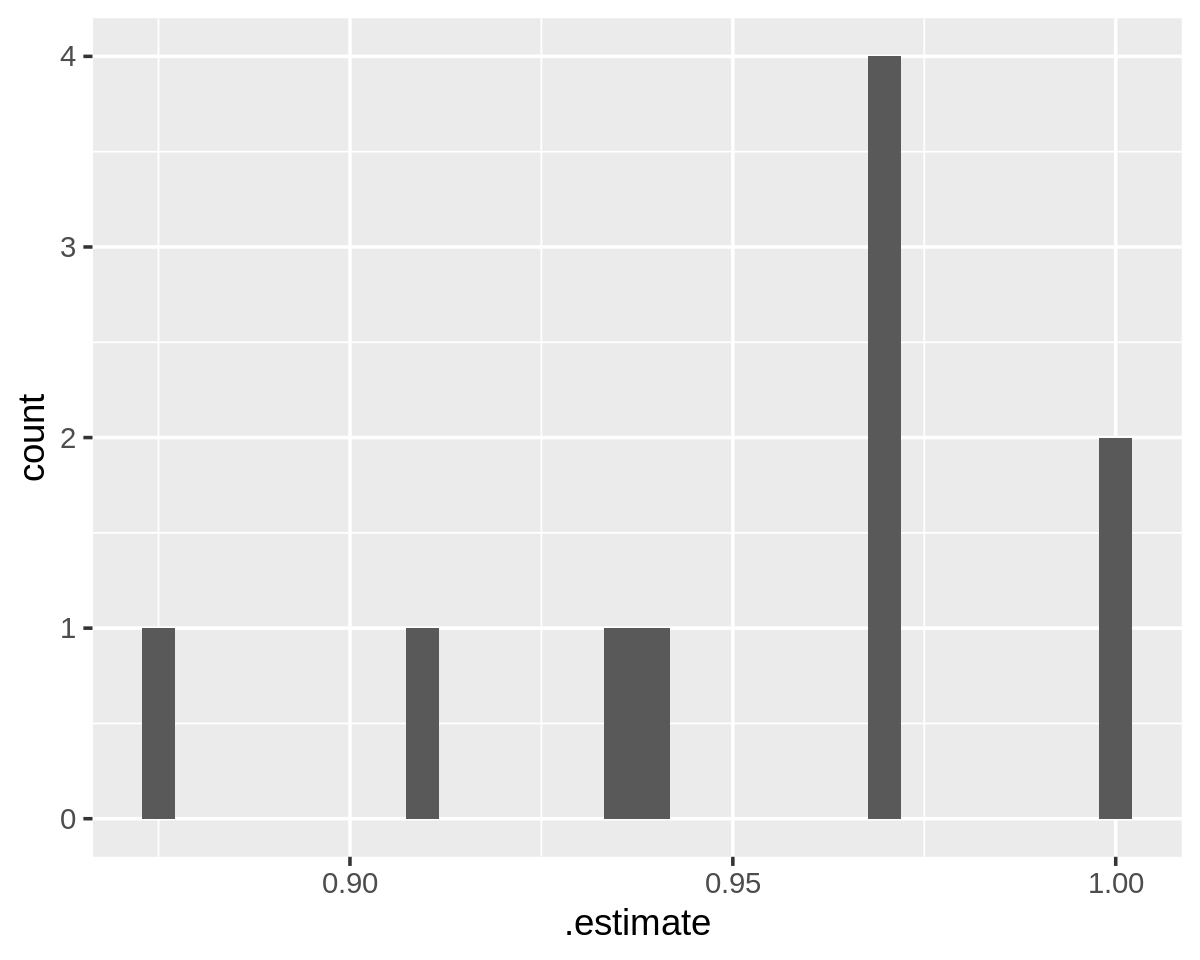

In [25]:
crossvalidation_list %>%
    dplyr::bind_rows() %>%
    ggplot2::ggplot() +
    ggplot2::geom_histogram(aes(x=.estimate))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable></variables><block type="pipe_R" id="-blIJ8hlt6c^Bo(!]@R*" x="-364" y="114"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="#l(Cd*|f{@%iIwdIhga-"><field name="VAR" id="t%HW{/ZE[3y`dFOSj]+G">crossvalidation_list</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="s`K8^Pm9:9c{t~S|TT8R"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value><value name="ADD1"><block type="ggplot_plus_R" id="#rn:.wV-/JO._jJMh6DP"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="gE%7/}bvFYRw_,s?dNwn"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">ggplot</field><data>ggplot2:ggplot</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="m{RDZRT%HVfeM{Cw?[J4"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_histogram</field><data>ggplot2:geom_histogram</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="~:]~0vKFKYVr]/{It#t."><field name="CODE">aes(x=.estimate)</field></block></value></block></value></block></value></block></xml>

-----------
**QUESTION:**

What is the range of F1 values and what is the most common F1 value?

**ANSWER: (click here to edit)**

*The range is about .88 to 1.00, and the most common F1 is about .97*

--------------------

Plot the grid search results from the inner folds to see what the best value for `penalty` is.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


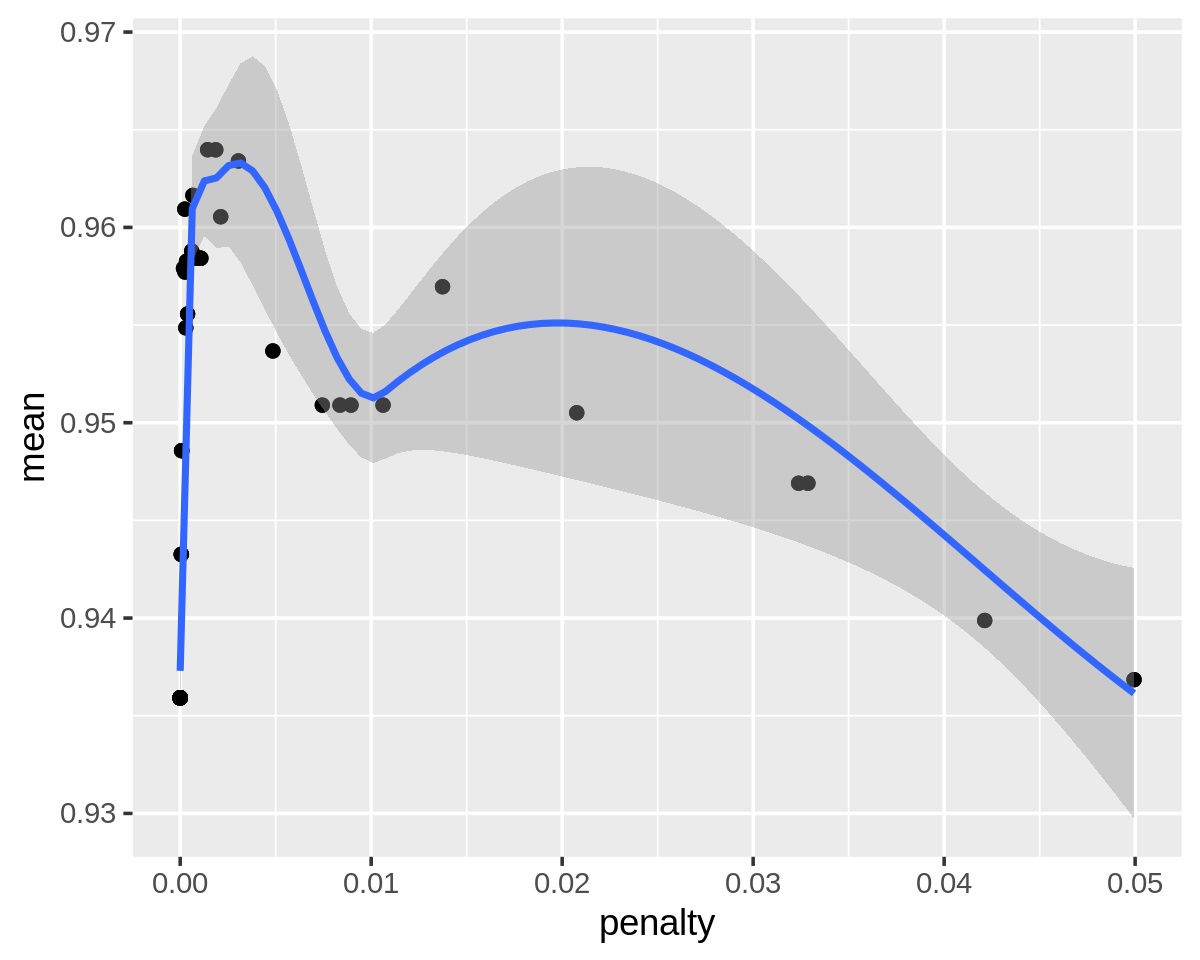

In [27]:
grid_search_list %>%
    dplyr::bind_rows() %>%
    ggplot2::ggplot(aes(x=penalty,y=mean)) +
    ggplot2::geom_point() +
    ggplot2::geom_jitter() +
    ggplot2::geom_smooth()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable></variables><block type="pipe_R" id="-blIJ8hlt6c^Bo(!]@R*" x="-359" y="110"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="#l(Cd*|f{@%iIwdIhga-"><field name="VAR" id="R?~/uY-!:J@?r*}f2Dj.">grid_search_list</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="s`K8^Pm9:9c{t~S|TT8R"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value><value name="ADD1"><block type="ggplot_plus_R" id="#rn:.wV-/JO._jJMh6DP"><mutation items="3"></mutation><value name="INPUT"><block type="varDoMethod_R" id="gE%7/}bvFYRw_,s?dNwn"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">ggplot</field><data>ggplot2:ggplot</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="~:]~0vKFKYVr]/{It#t."><field name="CODE">aes(x=penalty,y=mean)</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="m{RDZRT%HVfeM{Cw?[J4"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_point</field><data>ggplot2:geom_point</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="[KC2z(J8-85uG%}mtIg]"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_jitter</field><data>ggplot2:geom_jitter</data></block></value><value name="ADD2"><block type="varDoMethod_R" id="lntCw5^JdnBq@jr%e]5|"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_smooth</field><data>ggplot2:geom_smooth</data></block></value></block></value></block></xml>

-----------
**QUESTION:**

What is the best value for `penalty`?

**ANSWER: (click here to edit)**

*Based on the grid search results, the best value is between 0 and .005, probably about .003.*

--------------------

<!--  -->